# CSI #

The problem we are interested in solving is determining *causal* relationships within a timeseries dataset.  By causal, we mean that we can reduce variance in the estimate of a gene $i$ at any given timepoint given a gene (or set of genes—termed the *parental set* $S_{i,s}$ of the gene) at the previous time point.  The parental set is drawn from the powerset of the genes included in the data and truncated at some depth (i.e. maximum number of parents) in order to stop the model getting too "big".

## Model Definition ##

We define $\theta_i$ as the hyperparamaters associated with the gene $i$, and $\Sigma(X,\theta)$ the multivariate-normal covariance given by the squared-exponential kernel.  The probability of the expression data for the gene given parental set $S_{i,s}$ is therefore:
$$
P(X_i \mid X'_{S_{i,s}}, \theta_i) = \mathcal{N}(X_i, \Sigma(X'_{S_{i,s}}, \theta_i))
$$
Because we are interested in discovering causal relationships, we want to know which parental sets best explain our gene of interest.  We therefore want to weight the parental sets by their explanatory power, so we introduce $w_{i,j}$, constrained such that $\forall i \sum_j w_{i,j} = 1$.

The likelihood of our gene given the parental sets and associated weights is therefore:
$$
P(X_i \mid \theta_i, w_i) \propto \prod_s P(X_i \mid X'_{S_{i,s}}, \theta_i) ^ {w_{i,s}}
$$
We can perform expectation-maximisation of the above above model by interleaving minimisations of $\theta_i$ and reweightings of $w_i$.  We say the model has converged when the KL divergence of the reweight step goes below $10^{-5}$.

## Interpretation ##

The weight of each parental set are of most interest to biologists, and are interpreted as the probability of the parental set as having casual influence on the gene of interest.  The argument for causality is left as an exercise for the reader!

We are left with a high dimensional space that we need to visualise in order to gain much understanding.  One metaphor that users are accustomed to are network diagrams that specify which genes are influencing each other.  Two ways of extracting a single network suggested by Chris were to use the marginal likelihoods and the MAP network.

We represent this network as a adjacency matrix (weighted and nonsymmetric) where $N_{i,j}$ describes the likelihood of gene $i$ being influenced by gene $j$.

1. The **marginal-likelihood network** is simply the sum of all weights of target $i$ where the regulator $j$ is a member of the parental set:
$$
N_{i,j} = \!\!\sum_{s ,\, j \in S_{i,s}}\!\! w_{i,s}
$$
2. The **MAP network** (maximum a-posteriori network) simply distributes the weight over the members of the parental set that has the largest weight, $s = \text{argmax}_t w_{i,t}$:
$$
\hat N_{i,S_{i,s}} = w_{i,s}
$$
and is otherwise zero.



In [1]:
%matplotlib inline
%load_ext autoreload

%autoreload 2

In [2]:
import itertools as it

import numpy as np
import scipy as sp
import pandas as pd
import h5py as h5

import matplotlib.pyplot as plt
import seaborn as sns

import GPy

import csi

Read in data, then convert the second level (i.e. index=1) from strings to floats.  This conversion ensures that columns are recognised as "sorted" and `.loc` slicing works as expected.

In [3]:
inp = pd.read_csv("csi/testdata/Demo_DREAM.csv",index_col=0,header=[0,1])

inp.columns = pd.MultiIndex.from_tuples([(a,float(b)) for a,b in inp.columns],
                                        names=inp.columns.names)

I define `inpX` to be the inputs to the GP regressions and `inpY` the outputs.  Given time series upto $t$, `inpX` therefore contains indicies $1\dots t-1$ and `inpY` indicies $2\dots t$, i.e. both contain one less element than `inp`.

This is all somewhat complicated by the fact that we have replicates, I currently don't want to assume that every replicate has the same number of time points.  However, given the requirement that the time points are "evenly" spaced kind of implies that each replicate will always have exactly the same time points associated.

In [4]:
def getIndicies(x):
    """Returns indicies, [i], where item $x_i = x_{i-1}$."""
    prev = None
    for i, a in enumerate(x):
        if a == prev:
            yield i
        prev = a

ix = np.array(list(getIndicies([a for a,b in iter(inp.columns)])))
inpX = inp.iloc[slice(None),ix-1].T
inpY = inp.iloc[slice(None),ix].T

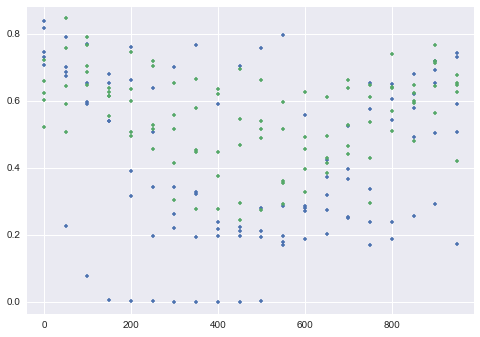

In [7]:
plt.plot([b for a,b in inpX.index],
         inpX[["Gene1","Gene2"]],'.');
plt.margins(0.04)

GP_regression.,Value,Constraint,Prior,Tied to
rbf.variance,0.167768177637,+ve,,
rbf.lengthscale,0.194863002638,+ve,,
Gaussian_noise.variance,0.00179223941796,+ve,,


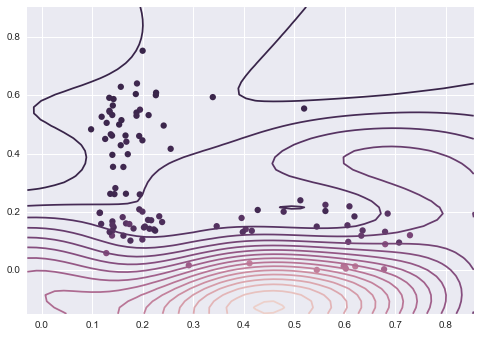

In [8]:
m = GPy.models.GPRegression(inpX[["Gene4","Gene8"]],inpY[["Gene7"]])
m.optimize()
m.plot(cmap=sns.cubehelix_palette(reverse=True, as_cmap=True));
m

In [9]:
cc = csi.Csi(inp)
em = cc.getEm()
em.setup(cc.allParents("Gene2",3))

KL Div: 8.89682e-07, hypers: [ 0.28589921  2.41672644  0.00575142]
CPU times: user 2.25 s, sys: 123 ms, total: 2.37 s
Wall time: 2.31 s


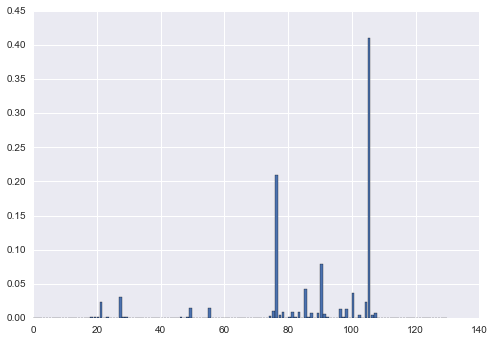

In [14]:
%%time
res = em.optimiseHypers()
print("KL Div: %g, hypers: %s" % (em.reweight(),str(em.hypers)))
plt.bar(range(len(em.weights)),em.weights)

In [ ]:
ll = em.logliks()
plt.plot(-np.sort(-ll));
for i in np.argsort(-ll):
    print("%3i: %6.2f = %s" % (i, ll[i],",".join(em.pset[i][0])))

In [ ]:
res = em.getResults()

In [ ]:
m = csi.map_of_list(cc.get_items())
with h5.File('results.h5','w') as f:
    res.write_hdf5(f.create_group('2'),m)

In [ ]:
import scipy.stats as sps
x = np.linspace(0,1,501)
plt.margins(0.04)
plt.plot(x,sps.beta.logpdf(x,0.01,0.9));

In [ ]:
res = em.getResults()
wei = pd.DataFrame(list(it.chain(res.getMarginalWeights())),
                   columns=["regulator","target","weight"])
# get down to the mean of each regulator and target
weim = wei.groupby(["regulator","target"]).mean()
weim /= weim.sum()

In [ ]:
reps = res.em.csi.get_replicates()
ilocs = [np.array(r.iloc[:-1]) for r in reps]
mu,var = res.em._predict_pset(res.pset[1], res.hypers)
[dict(mu=mu[l-i,:],var=var[l-i,:]) for i,l in enumerate(ilocs)]

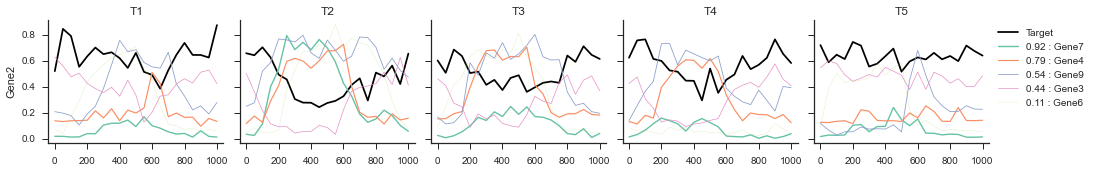

In [46]:
arr = {}
for w,p in zip(em.weights,em.pset):
    for i in p[0]:
        arr[i] = arr.get(i,0) + w
df = pd.DataFrame(list(arr.items()),columns=['parent','weight'])
df = df[df.weight >= 0.1]
df.sort("weight",ascending=False,inplace=True)

pert = inp.columns.levels[0]
target = em.pset[0][1]

with sns.axes_style(style='ticks'):
    fig, axs = plt.subplots(nrows=1, ncols=len(pert),
                            sharex=True, sharey=True,
                            figsize=(14, 2.5))

pal = sns.color_palette("Set2", len(df))

for per,ax in zip(pert,axs):
    ax.margins(0.04)
    ax.set_title(per)
    d = inp.loc[target,per]
    ax.plot(d.index, d,'k',label="Target")
    for (i,r),col in zip(df.iterrows(),pal):
        d = inp.loc[r.parent,per]
        lab = "{w:.2f} : {p}".format(p=r.parent,w=r.weight)
        ax.plot(d.index, d, lw=r.weight*1.5,label=lab,color=col)

axs[-1].legend(loc='upper left', bbox_to_anchor=(1, 1));
axs[0].set_ylabel(target)

sns.despine()

fig.tight_layout()

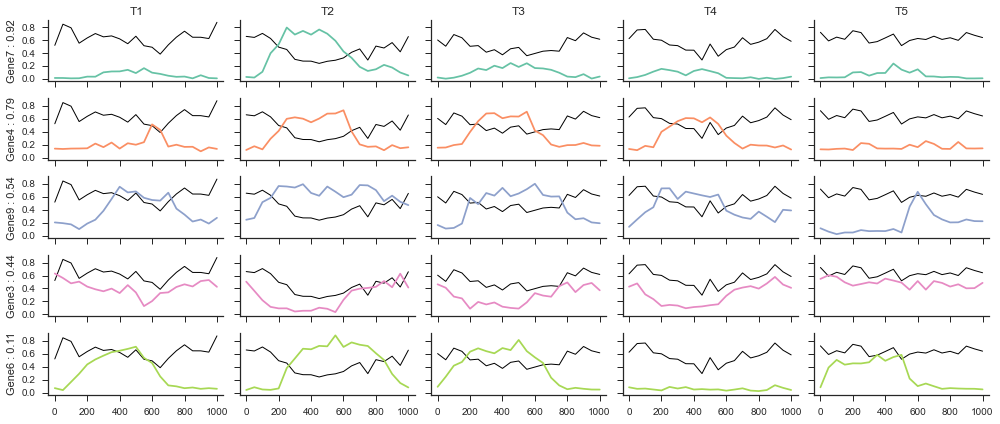

In [49]:
arr = {}
for w,p in zip(em.weights,em.pset):
    for i in p[0]:
        arr[i] = arr.get(i,0) + w
df = pd.DataFrame(list(arr.items()),columns=['parent','weight'])
df = df[df.weight >= 0.1]
df.sort("weight",ascending=False,inplace=True)

pert = inp.columns.levels[0]
target = em.pset[0][1]

with sns.axes_style(style='ticks'):
    fig, axs = plt.subplots(nrows=len(df), ncols=len(pert),
                            sharex=True, sharey=True,
                            figsize=(14, 1+len(df)))

pal = sns.color_palette("Set2", len(df))

for (i,r),axr,col in zip(df.iterrows(), axs, pal):
    for per,ax in zip(pert,axr):
        ax.margins(0.04)
        d = inp.loc[target,per]
        ax.plot(d.index, d,'k',lw=1)
        d = inp.loc[r.parent,per]
        ax.plot(d.index, d,c=col)
    lab = "{p} : {w:.2f}".format(p=r.parent,w=r.weight)
    axr[0].set_ylabel(lab)
    # axr[-1].yaxis.set_label_position("right")

for per,ax in zip(pert,axs[0]):
    ax.set_title(per)

sns.despine()
fig.tight_layout()